In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from scipy.special import expit as logistic

import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.25.1


In [2]:
az.style.use("arviz-darkgrid")

RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)


def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

In [3]:
N = 100

true_a, true_b, predictor = 0.5, 3.0, rng.normal(loc=2, scale=6, size=N)
true_mu = true_a + true_b * predictor
true_sd = 2.0

outcome = rng.normal(loc=true_mu, scale=true_sd, size=N)

f"{predictor.mean():.2f}, {predictor.std():.2f}, {outcome.mean():.2f}, {outcome.std():.2f}"

'1.59, 5.69, 4.97, 17.54'

In [4]:
predictor_scaled = standardize(predictor)
outcome_scaled = standardize(outcome)

f"{predictor_scaled.mean():.2f}, {predictor_scaled.std():.2f}, {outcome_scaled.mean():.2f}, {outcome_scaled.std():.2f}"

'-0.00, 1.00, -0.00, 1.00'

In [5]:
with pm.Model() as model_1:
    a = pm.Normal("a", 0.0, 10.0)
    b = pm.Normal("b", 0.0, 10.0)

    mu = a + b * predictor_scaled
    sigma = pm.Exponential("sigma", 1.0)

    pm.Normal("obs", mu=mu, sigma=sigma, observed=outcome_scaled)
    idata = pm.sample_prior_predictive(draws=50, random_seed=rng)

Sampling: [a, b, obs, sigma]


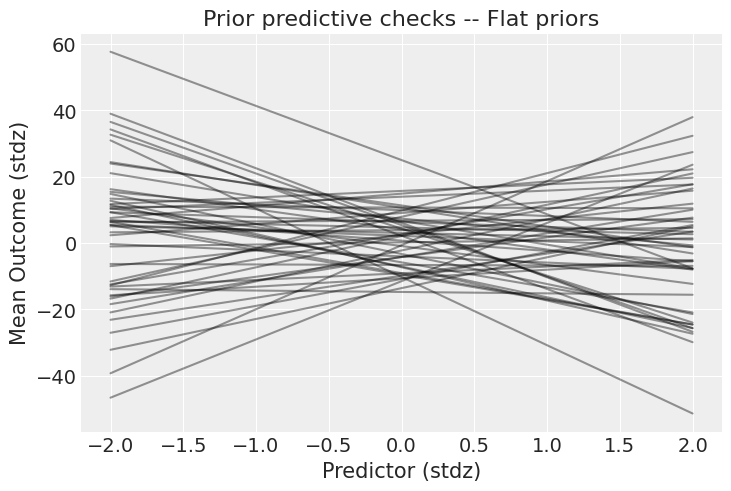

In [6]:
_, ax = plt.subplots()

x = xr.DataArray(np.linspace(-2, 2, 50), dims=["plot_dim"])
prior = idata.prior
y = prior["a"] + prior["b"] * x

ax.plot(x, y.stack(sample=("chain", "draw")), c="k", alpha=0.4)

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Mean Outcome (stdz)")
ax.set_title("Prior predictive checks -- Flat priors");

In [7]:
with pm.Model() as model_1:
    a = pm.Normal("a", 0.0, 0.5)
    b = pm.Normal("b", 0.0, 1.0)

    mu = a + b * predictor_scaled
    sigma = pm.Exponential("sigma", 1.0)

    pm.Normal("obs", mu=mu, sigma=sigma, observed=outcome_scaled)
    idata = pm.sample_prior_predictive(draws=50, random_seed=rng)

Sampling: [a, b, obs, sigma]


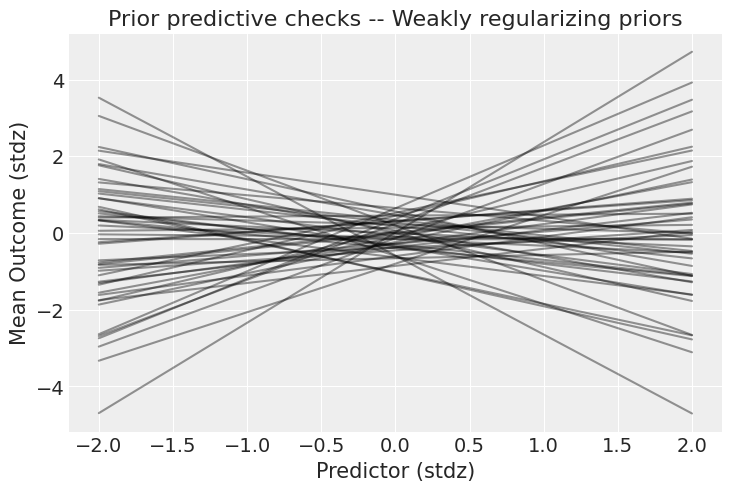

In [8]:
_, ax = plt.subplots()

x = xr.DataArray(np.linspace(-2, 2, 50), dims=["plot_dim"])
prior = idata.prior
y = prior["a"] + prior["b"] * x

ax.plot(x, y.stack(sample=("chain", "draw")), c="k", alpha=0.4)

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Mean Outcome (stdz)")
ax.set_title("Prior predictive checks -- Weakly regularizing priors");

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1 seconds.


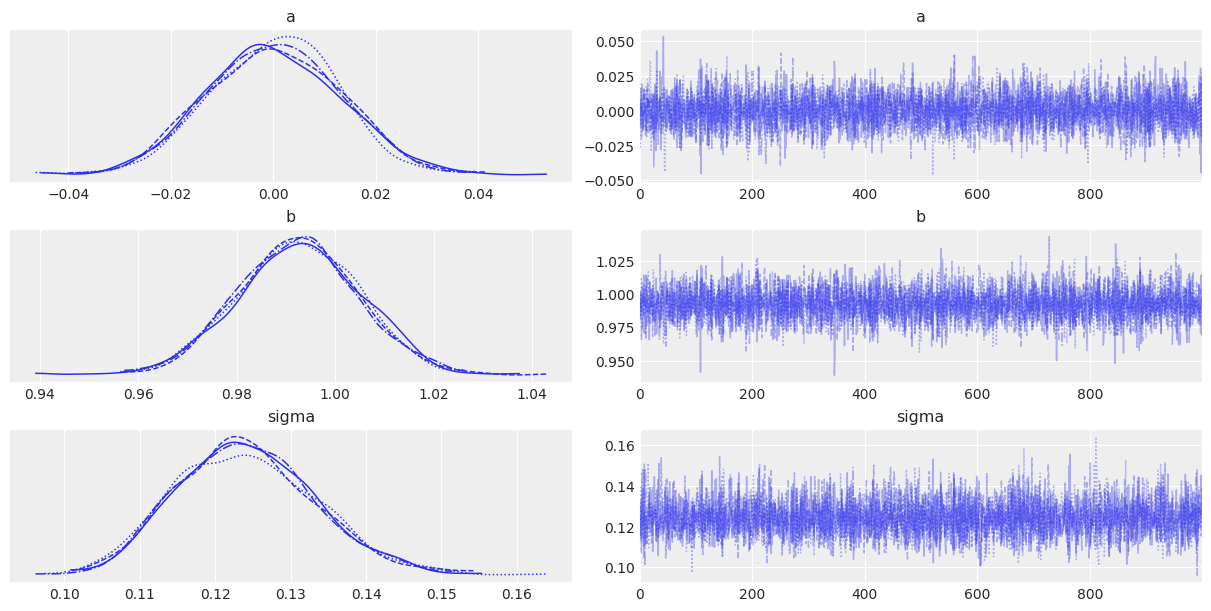

In [9]:
with model_1:
    idata.extend(pm.sample(1000, tune=2000, random_seed=rng))

az.plot_trace(idata);

In [10]:
with model_1:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=rng)

Sampling: [obs]


Output()

In [11]:
idata.posterior_predictive

<xarray.Dataset> Size: 3MB
Dimensions:    (chain: 4, draw: 1000, obs_dim_0: 100)
Coordinates:
  * chain      (chain) int64 32B 0 1 2 3
  * draw       (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * obs_dim_0  (obs_dim_0) int64 800B 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
Data variables:
    obs        (chain, draw, obs_dim_0) float64 3MB -0.3941 -0.003109 ... 0.7515
Attributes:
    created_at:                 2025-08-22T06:19:07.664736+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.25.1

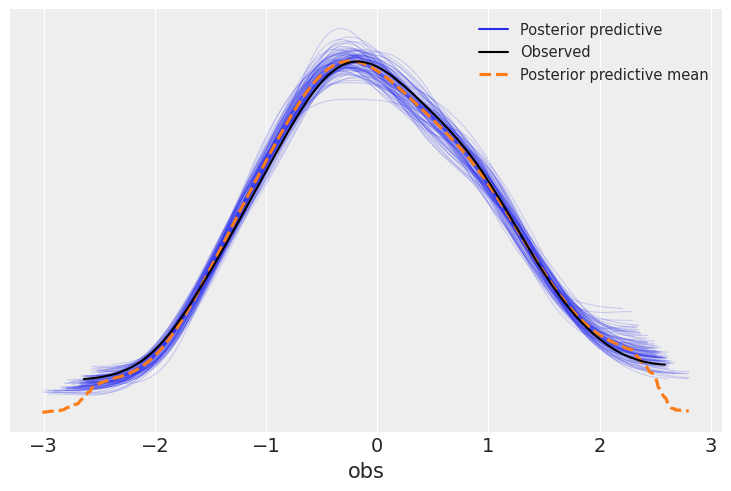

In [12]:
az.plot_ppc(idata, num_pp_samples=100);

In [13]:
post = idata.posterior
mu_pp = post["a"] + post["b"] * xr.DataArray(predictor_scaled, dims=["obs_id"])

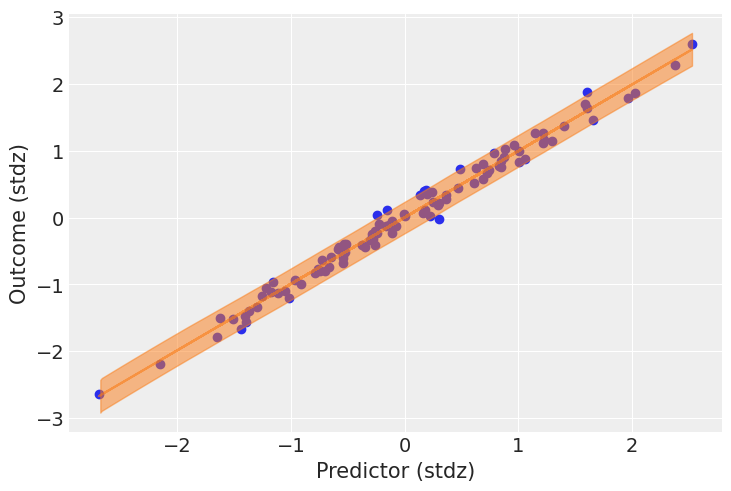

In [14]:
_, ax = plt.subplots()

ax.plot(
    predictor_scaled, mu_pp.mean(("chain", "draw")), label="Mean outcome", color="C1", alpha=0.6
)
ax.scatter(predictor_scaled, idata.observed_data["obs"])
az.plot_hdi(predictor_scaled, idata.posterior_predictive["obs"])

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Outcome (stdz)");